In [1]:
import torch,torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import *
from torch import nn
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    LabelEncoder,
    Normalizer,
)
from torch.optim import *
device = torch.device('cuda:0')

In [2]:
data = pd.read_csv('btcNewsToPrice2.csv')

In [3]:
data.head()

,date,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,...,top_32,top_33,top_34,top_35,price,open,high,low,vol.,change %
0,2015-07-12,bitcoin the next logical step in the rise of u...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,310.4,292.0,315.9,291.3,120.70K,6.33%
1,2015-07-13,bitgive foundation announces new initiatives a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,290.4,310.4,310.9,276.9,146.85K,-6.47%
2,2015-07-14,keynote 2015 harnessing the distributed ledge...,the blockchain towards crypto sovereignty ...,coinbase outage is a reminder to not store bit...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,287.0,290.4,297.0,285.2,60.62K,-1.17%
3,2015-07-15,patrick byrne says will be able to replace w...,bitcoin in review interesting trends in q1 of...,cloudminr user accounts hacked data sold for ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,283.4,287.0,292.9,283.2,59.58K,-1.23%
4,2015-07-16,2015 q1 bitcoin investment trumps 2014 numbers...,cash back vs bitcoin why bitcoin can be super...,force or mathematics fiat vs cryptocurrency ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,276.6,283.4,290.8,273.3,121.32K,-2.41%


In [4]:
X = data['date'].tolist()

In [5]:
new_X = []

In [6]:
for x in X:
    x = x.split('-')
    x = int(f'{x[0]}{x[1]}{x[2]}')
    new_X.append(x)

In [7]:
X = new_X

In [8]:
X = torch.from_numpy(np.array(new_X))

In [9]:
y = torch.from_numpy(np.array(data['price'].tolist()))

In [10]:
data.columns

Index(['date', 'top_0', 'top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'top_6',
       'top_7', 'top_8', 'top_9', 'top_10', 'top_11', 'top_12', 'top_13',
       'top_14', 'top_15', 'top_16', 'top_17', 'top_18', 'top_19', 'top_20',
       'top_21', 'top_22', 'top_23', 'top_24', 'top_25', 'top_26', 'top_27',
       'top_28', 'top_29', 'top_30', 'top_31', 'top_32', 'top_33', 'top_34',
       'top_35', 'price', 'open', 'high', 'low', 'vol.', 'change %'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split

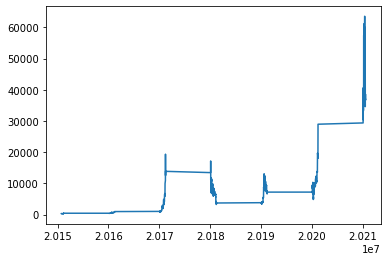

In [12]:
plt.figure()
plt.plot(X,y)
plt.show()

In [13]:
class LSTMPredictor(Module):
    def __init__(self,n_hidden=512):
        super().__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = LSTMCell(1,self.n_hidden).to(device)
        self.lstm2 = LSTMCell(self.n_hidden,self.n_hidden).to(device)
        self.linear = Linear(self.n_hidden,1).to(device)
    
    def forward(self,X,future=0):
        outputs = []
        n_samples = X.size(0)
        h_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        for input_t in X.split(1,dim=1):
            input_t = input_t.to(device)
            h_t = h_t.to(device)
            c_t = c_t.to(device)
            h_t,c_t = self.lstm1(input_t,(h_t,c_t))
            h_t = h_t.to(device)
            c_t = c_t.to(device)
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            output = self.linear(h_t2)
            output = output.to(device)
            outputs.append(output)
        for i in range(future):
            h_t,c_t = self.lstm1(output,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [14]:
# model = LSTMPredictor().cuda()
# model = model.cuda()
# model = model.to(device)

In [15]:
epochs = 12

In [16]:
batch_size = 32

In [17]:
from tqdm import tqdm
import wandb
PROJECT_NAME = 'Bitcoin-Price-Prediction'

In [18]:
# criterion = L1Loss().to(device).cuda()
# optimizer = LBFGS(model.parameters(),lr=0.8)

In [19]:
import cv2

In [20]:
y_batch = y

In [21]:
torch.cuda.empty_cache()

In [22]:
data_input = torch.from_numpy(np.array(y_batch)).view(1,-1)[:3,:-1].float().cuda().to(device)
data_target = torch.from_numpy(np.array(y_batch)).view(1,-1)[:3,1:].float().cuda().to(device)

In [23]:
data_input.shape

torch.Size([1, 2145])

In [ ]:
# torch.cuda.empty_cache()
# model = LSTMPredictor().cuda()
# model = model.cuda()
# model = model.to(device)
# criterion = MSELoss().to(device).cuda()
# optimizer = LBFGS(model.parameters(),lr=0.8)
# wandb.init(project=PROJECT_NAME,name=f'baseline')
# for _ in tqdm(range(epochs)):
#     for idx in range(0,len(data_input)):
#         data_input_batch = data_input[idx:idx+batch_size].view(1,-1)[:3,:-1].float().cuda().to(device)
#         data_target_batch = data_input[idx:idx+batch_size].view(1,-1)[:3,1:].float().cuda().to(device)
#         torch.cuda.empty_cache()
#         def closure():
#             optimizer.zero_grad()
#             data_input_batch.cuda()
#             data_target_batch.cuda()
#             model.cuda()
#             out = model(data_input_batch.cuda()).cuda()
#             out.cuda()
#             loss = criterion(out,data_target_batch)
#             wandb.log({'loss':loss.item()})
#             loss.backward()
#             return loss
#         optimizer.step(closure)
#         with torch.no_grad():
#             future = 25
#             pred = model(data_input_batch,future=future)
#             loss = criterion(pred[:,:-future],data_target_batch)
#             y = pred.to('cpu').detach().numpy()
#             wandb.log({'Val Loss':loss.item()})
#         plt.figure(figsize=(12,6))
#         n = data_input_batch.shape[1]
#         def draw(y_i,color):
#             plt.plot(np.arange(n),data_target_batch.cpu().view(-1),color)
#             plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
#         draw(y[0],'r')
#         plt.savefig('./preds/img.png')
#         plt.close()
#         wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
# wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


 94%|█████████▍| 94/100 [36:57<02:21, 23.59s/it]

In [ ]:
pres = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler(),Normalizer()]
for pre in pres:
    pre = pre
    pre.fit(y)
    y = pre.transform(y)
    y_batch = y
    data_input = torch.from_numpy(np.array(y_batch)).view(1,-1)[:3,:-1].float().cuda().to(device)
    data_target = torch.from_numpy(np.array(y_batch)).view(1,-1)[:3,1:].float().cuda().to(device)
    torch.cuda.empty_cache()
    model = LSTMPredictor().cuda()
    model = model.cuda()
    model = model.to(device)
    criterion = MSELoss().to(device).cuda()
    optimizer = LBFGS(model.parameters(),lr=0.8)
    wandb.init(project=PROJECT_NAME,name=f'{pre}-pre')
    for _ in tqdm(range(epochs)):
        for idx in range(0,len(data_input)):
            data_input_batch = data_input[idx:idx+batch_size].view(1,-1)[:3,:-1].float().cuda().to(device)
            data_target_batch = data_input[idx:idx+batch_size].view(1,-1)[:3,1:].float().cuda().to(device)
            torch.cuda.empty_cache()
            def closure():
                optimizer.zero_grad()
                data_input_batch.cuda()
                data_target_batch.cuda()
                model.cuda()
                out = model(data_input_batch.cuda()).cuda()
                out.cuda()
                loss = criterion(out,data_target_batch)
                wandb.log({'loss':loss.item()})
                loss.backward()
                return loss
            optimizer.step(closure)
            with torch.no_grad():
                future = 25
                pred = model(data_input_batch,future=future)
                loss = criterion(pred[:,:-future],data_target_batch)
                y = pred.to('cpu').detach().numpy()
                wandb.log({'Val Loss':loss.item()})
            plt.figure(figsize=(12,6))
            n = data_input_batch.shape[1]
            def draw(y_i,color):
                plt.plot(np.arange(n),data_target_batch.cpu().view(-1),color)
                plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
            draw(y[0],'r')
            plt.savefig('./preds/img.png')
            plt.close()
            wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
    wandb.finish()

In [ ]:
# lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# for lr in lrs:
#     torch.cuda.empty_cache()
#     model = LSTMPredictor().cuda()
#     model = model.cuda()
#     model = model.to(device)
#     criterion = MSELoss().to(device).cuda()
#     optimizer = LBFGS(model.parameters(),lr=lr)
#     wandb.init(project=PROJECT_NAME,name=f'lrs-{lr}')
#     for _ in tqdm(range(epochs)):
#         torch.cuda.empty_cache()
#         def closure():
#             optimizer.zero_grad()
#             data_input.cuda()
#             data_target.cuda()
#             model.cuda()
#             out = model(data_input.cuda()).cuda()
#             out.cuda()
#             loss = criterion(out,data_target)
#             wandb.log({'loss':loss.item()})
#             loss.backward()
#             return loss
#         optimizer.step(closure)
#         with torch.no_grad():
#             future = 125
#             pred = model(data_input,future=future)
#             loss = criterion(pred[:,:-future],data_target)
#             y = pred.to('cpu').detach().numpy()
#             wandb.log({'Val Loss':loss.item()})
#         plt.figure(figsize=(12,6))
#         n = data_input.shape[1]
#         def draw(y_i,color):
#             plt.plot(np.arange(n),data_target.cpu().view(-1),color)
#             plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
#         draw(y[0],'r')
#         plt.savefig('./preds/img.png')
#         plt.close()
#         wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
#     wandb.finish()

In [ ]:
# criterions = [MSELoss(),L1Loss()]
# for criterion in criterions:
#     torch.cuda.empty_cache()
#     model = LSTMPredictor().cuda()
#     model = model.cuda()
#     model = model.to(device)
#     criterion = criterion.to(device).cuda()
#     optimizer = LBFGS(model.parameters(),lr=)
#     wandb.init(project=PROJECT_NAME,name=f'criterion-{criterion}')
#     for _ in tqdm(range(epochs)):
#         torch.cuda.empty_cache()
#         def closure():
#             optimizer.zero_grad()
#             data_input.cuda()
#             data_target.cuda()
#             model.cuda()
#             out = model(data_input.cuda()).cuda()
#             out.cuda()
#             loss = criterion(out,data_target)
#             wandb.log({'loss':loss.item()})
#             loss.backward()
#             return loss
#         optimizer.step(closure)
#         with torch.no_grad():
#             future = 125
#             pred = model(data_input,future=future)
#             loss = criterion(pred[:,:-future],data_target)
#             y = pred.to('cpu').detach().numpy()
#             wandb.log({'Val Loss':loss.item()})
#         plt.figure(figsize=(12,6))
#         n = data_input.shape[1]
#         def draw(y_i,color):
#             plt.plot(np.arange(n),data_target.cpu().view(-1),color)
#             plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
#         draw(y[0],'r')
#         plt.savefig('./preds/img.png')
#         plt.close()
#         wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
#     wandb.finish()

In [ ]:
# n_hiddens = [16,32,64,128,256,512,1024,2048]
# for n_hidden in n_hiddens:
#     torch.cuda.empty_cache()
#     model = LSTMPredictor(n_hidden=n_hidden).cuda()
#     model = model.cuda()
#     model = model.to(device)
#     criterion = .to(device).cuda()
#     optimizer = LBFGS(model.parameters(),lr=)
#     wandb.init(project=PROJECT_NAME,name=f'n_hidden-{n_hidden}')
#     for _ in tqdm(range(epochs)):
#         torch.cuda.empty_cache()
#         def closure():
#             optimizer.zero_grad()
#             data_input.cuda()
#             data_target.cuda()
#             model.cuda()
#             out = model(data_input.cuda()).cuda()
#             out.cuda()
#             loss = criterion(out,data_target)
#             wandb.log({'loss':loss.item()})
#             loss.backward()
#             return loss
#         optimizer.step(closure)
#         with torch.no_grad():
#             future = 125
#             pred = model(data_input,future=future)
#             loss = criterion(pred[:,:-future],data_target)
#             y = pred.to('cpu').detach().numpy()
#             wandb.log({'Val Loss':loss.item()})
#         plt.figure(figsize=(12,6))
#         n = data_input.shape[1]
#         def draw(y_i,color):
#             plt.plot(np.arange(n),data_target.cpu().view(-1),color)
#             plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
#         draw(y[0],'r')
#         plt.savefig('./preds/img.png')
#         plt.close()
#         wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
#     wandb.finish()